<a href="https://colab.research.google.com/github/tmiessa/mdc-defaultcredit/blob/development/mdc_defaultcredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDC 2019 - INF-0619 - Default of Credit Cards


## Alunos
* Matheus Pacheco
* Raphael Santos
* Renato Dias
* Tiago Miessa

## Imports

In [0]:
import sys
import os 
import requests
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample

## Download do Dataset

In [2]:
## download files
if os.path.isfile('UCI_Credit_Card.csv'):
    print('file already exists!')
else:
    print('file does not exists, downloading...')
    myfile = requests.get('https://onedrive.live.com/download?cid=F1E435813B40678A&resid=F1E435813B40678A%218086&authkey=AE0BdkzcP5BTU-M')
    open('UCI_Credit_Card.csv', 'wb').write(myfile.content)
    print('file downloaded')

file does not exists, downloading...
file downloaded


In [0]:
df = pd.read_csv('UCI_Credit_Card.csv')

# Rename de coluna fora do padrão e do target, para facilitar referência futura
df.rename(columns={'PAY_0':'PAY_1','default.payment.next.month':'DEFAULTED'}, inplace=True)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULTED
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Análise Exploratória Inicial

### Verificação de Consistência das Features

In [0]:
df[['LIMIT_BAL', 'AGE']].describe()

A feature `LIMIT_BAL`, que indica o limite de crédito do cartão, varia de 10.000 a 1.000.000 NT Dólares, e a idade varia de 21 a 79 anos.


In [0]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

In [0]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].apply(pd.Series.value_counts).fillna(0).astype(int)

**Features PAY_X**

As features `PAY_X` indicam o pagamento dos meses de Setembro de 2005 a Abril 2005, onde podem assumir os seguintes valores:

* **`-1:`** pago devidamente
* **`1:`** atraso no pagamento de 1 mês
* **`2:`** atraso no pagamento de 2 meses
* **`X:`** atraso no pagamento de X meses (limite superior = 9)

**Problemas encontrados:**

*   Valores -2 e 0, sem documentação





In [0]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

**Features BILL_AMTX**

As features `BILL_AMTX` indicam o valor da fatura do cartão de crédito nos meses de Setembro 2005 (BILL_AMT1) a Abril 2005 (BILL_AMT6)

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.

In [0]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

In [0]:
df[['SEX','EDUCATION', 'MARRIAGE']].describe()

In [0]:
df[['SEX','EDUCATION', 'MARRIAGE']].apply(pd.Series.value_counts).fillna(0).astype(int)

**Features SEX, EDUCATION e MARRIAGE**

* **`SEX:`** indica o gênero do cliente (1: masculino, 2: feminino)
* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)
* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)
* Valores não documentados para **`MARRIAGE`** (0)

In [0]:
df['DEFAULTED'].value_counts()

### Investigação da Distribuição dos Dados

In [0]:
df['DEFAULTED'].value_counts().plot(kind='bar');

## Pivotamento (para análise futura)

Para facilitar a análise de evolução no tempo das colunas PAY_N, BILL_AMTN e PAY_AMTN, definimos o método abaixo para fazer o pivotamento das informações:

In [0]:
def pivotAgg(row1):
    res = np.concatenate( ( 
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1','BILL_AMT1','PAY_AMT1','DEFAULTED']].append(pd.Series({'DATE':date(2005,9,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2','BILL_AMT2','PAY_AMT2','DEFAULTED']].append(pd.Series({'DATE':date(2005,8,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_3','BILL_AMT3','PAY_AMT3','DEFAULTED']].append(pd.Series({'DATE':date(2005,7,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_4','BILL_AMT4','PAY_AMT4','DEFAULTED']].append(pd.Series({'DATE':date(2005,6,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_5','BILL_AMT5','PAY_AMT5','DEFAULTED']].append(pd.Series({'DATE':date(2005,5,1)}))],
        [row1[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_6','BILL_AMT6','PAY_AMT6','DEFAULTED']].append(pd.Series({'DATE':date(2005,4,1)}))]
    ))
    return res

# Outra ideia a ser explorada: usar o melt para cada coluna alvo, ao invés de todas de uma vez (value_vars not set: everything else)
# test = df.melt(id_vars=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'])
# test.reset_index(drop=True,inplace=True)
# test.head()

In [0]:
pdf = pd.DataFrame(np.concatenate([ pivotAgg(row[1]) for row in df.iterrows()]))
pdf.columns = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAYMENT STATUS','BILL AMOUNT','PAID AMOUNT','DEFAULTED', 'DATE']
pdf.to_csv('UCI_Credit_Card_Pivoted.csv', index=False)

Um ponto interessante é que o banco recebe muito menos do que o devido, com cerca de 11%:

In [0]:
pdf['PAID AMOUNT'].sum()/pdf['BILL AMOUNT'].sum()

## Construção do Baseline

Serão construídos dois modelos, para verificação da acurácia antes que qualquer pré-processamento (com exceção de normalização) seja feito nos dados. O motivo para isso é que o problema pode estar na descrição, ao invés de no conjunto.



In [0]:
# Campo ID será ignorado, por ser chave única
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=0.3, random_state=42 )

scaler = StandardScaler()

z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

### Regressão Logística

In [0]:
## split train and test set
y = df['DEFAULTED'].values
x = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].values
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, stratify=y, random_state=42)


print('different values of y: %s' % np.unique(y))

print('y_train distribution - label0: %d / label1: %d' % (len(y_train)-sum(y_train), sum(y_train)))
print('y_test distribution - label0: %d / label1: %d' % (len(y_test)-sum(y_test), sum(y_test)))


different values of y: [0 1]
y_train distribution - label0: 16324 / label1: 4676
y_test distribution - label0: 7040 / label1: 1960


In [0]:
## downsampling class 0
#tmp_nopay = np.column_stack((x_train[y_train==0], y_train[y_train==0]))
#tmp_pay = np.column_stack((x_train[y_train==1], y_train[y_train==1]))

In [0]:
#tmp_nopay = resample(tmp_nopay, replace=False, n_samples=len(y_train[y_train==1]), random_state=42)
#tmp_downsampled = np.concatenate([tmp_nopay, tmp_pay])

In [0]:
#x_train_resampled = tmp_downsampled[:,:-1]
#y_train_resampled = tmp_downsampled[:,-1:]

Logistic Regression
Balanced Accuracy: 67.35%


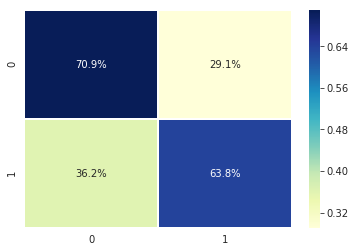

In [0]:
## logistic regression
# logreg = LogisticRegression(random_state=42, class_weight='balanced').fit(x_train, y_train)
# y_pred = logreg.predict(x_test)
logreg = LogisticRegression(random_state=42, solver = 'lbfgs', class_weight='balanced').fit(z_train, y_train)
y_pred = logreg.predict(z_test)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression')
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, y_pred)*100))

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito

r = cm/cm.sum(axis=1)[:,np.newaxis]
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

### SVM

In [0]:
# C foi alterado de 0.001 a 10, melhor valor foi 1 (que é o default)
svm = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svm.fit(z_train, y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=999,
    shrinking=True, tol=0.001, verbose=False)

SVM - SVC
Balanced Accuracy: 69.91%


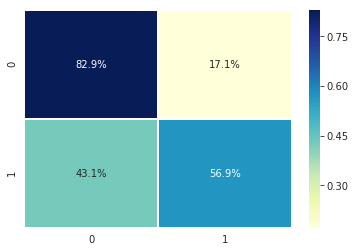

In [0]:
predictions = svm.predict(z_test)

print('SVM - SVC')
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

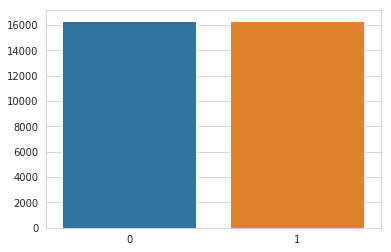

In [0]:
# Dados estão desbalanceados - usar um SMOTE ajudaria?
# Para o SVM provavelmente não, por conta de toda a ideia por trás dele. Mas checarei de qualquer maneira, para ter certeza

smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoter.fit_resample(z_train, y_train)

defaultedS = np.unique(sy_train, return_counts=True)
sns.barplot(defaultedS[0],defaultedS[1])

In [0]:
svmS = SVC(kernel='rbf', C=1, gamma='auto', random_state=999)
svmS.fit(sz_train, sy_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=999,
    shrinking=True, tol=0.001, verbose=False)

SVM - SVC SMOTED
Balanced Accuracy: 69.91%


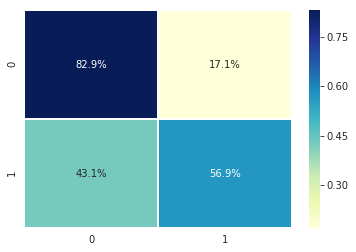

In [0]:
predictions = svmS.predict(z_test)

print('SVM - SVC SMOTED')
print('Balanced Accuracy: %.2f%%' % (balanced_accuracy_score(y_test, predictions)*100))

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

## Análise Aprofundada dos Dados

### Feature Selection

 - Análise de correlação
 - Análise de importância para um classificador do algoritmo GBM

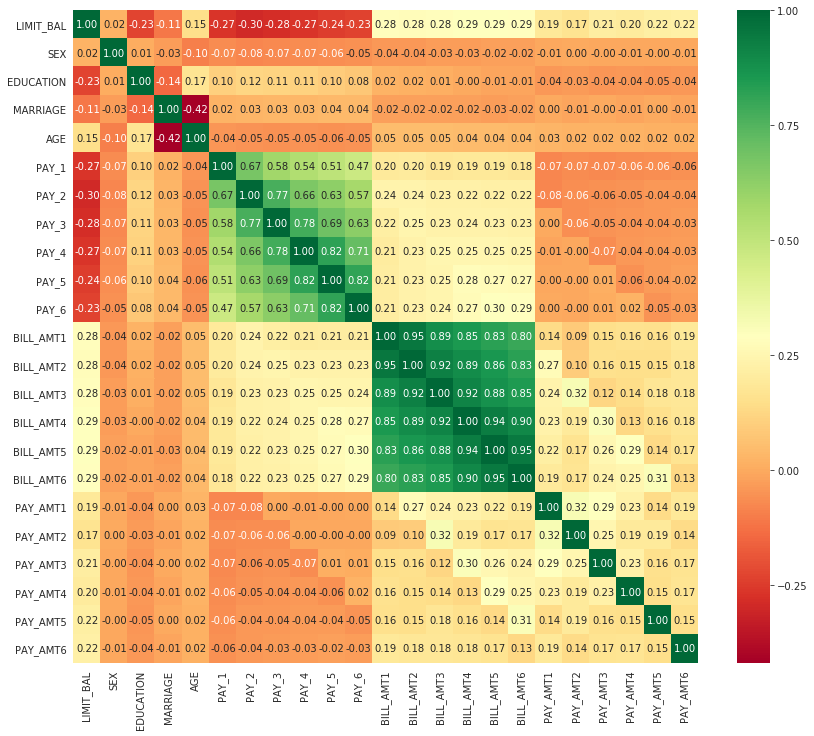

In [0]:
#get correlations of each features in dataset
corrmat = x_train.corr()
top_corr_features = corrmat.index
#plot heat map
plt.figure(figsize=(14,12))
g=sns.heatmap(x_train[top_corr_features].corr(), annot=True, cmap="RdYlGn", fmt='.2f')

In [0]:
gbm = GradientBoostingClassifier()
gbm.fit(sz_train, sy_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Balanced Accuracy:  68.71


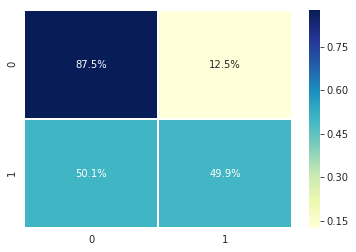

In [0]:
predictions = gbm.predict(z_test)

print('Balanced Accuracy: ', np.around(balanced_accuracy_score(y_test, predictions)*100, 2) )

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

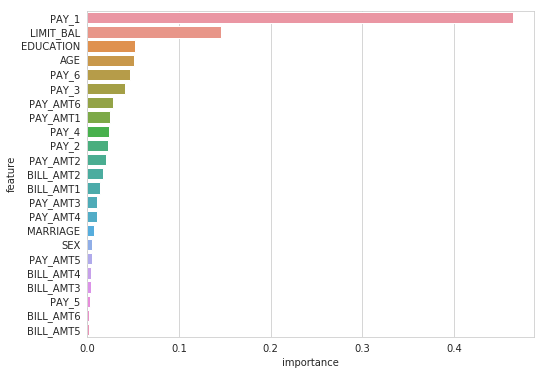

In [0]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbm.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)


Considerações:
- As features referentes ao total das contas possuem alta correlação entre si, mas para o classificador GBM não foram especiamente relevantes
- Selecionamos com base nas features mais relevantes um subconjunto, para treinar um novo classificador SVM e comparar o resultado

In [0]:
fx_train = x_train.loc[:,['EDUCATION','AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1']]
fx_test = x_test.loc[:,['EDUCATION','AGE','LIMIT_BAL','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','PAY_AMT1']]

scaler2 = StandardScaler()

fz_train = scaler2.fit_transform(fx_train)
fz_test = scaler2.transform(fx_test)

Balanced Accuracy:  69.86


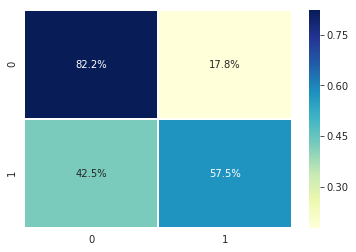

In [0]:
svm2 = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svm2.fit(fz_train, y_train)

predictions = svm2.predict(fz_test)

print('Balanced Accuracy: ', np.around(balanced_accuracy_score(y_test, predictions)*100, 2) )

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

### Limpeza dos dados

#### **Features BILL_AMTX**

**Problemas encontrados:**

* Foram encontrados valores negativos em todos os meses.


In [11]:
paymentFields = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
ownedFields = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

df[(df.BILL_AMT1 < 0) & (df.BILL_AMT2 <0)].head(5)[ ['ID'] + paymentFields + ownedFields]

,ID,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
26,27,0.0,1000.0,0.0,500.0,0.0,1000.0,-109.0,-425.0,259.0,-57.0,127.0,-189.0
68,69,0.0,0.0,20161.0,0.0,7319.0,13899.0,-190.0,-9850.0,-9850.0,10311.0,10161.0,7319.0
101,102,223.0,33178.0,1171.0,1197.0,1250.0,5000.0,-81.0,-303.0,32475.0,32891.0,33564.0,34056.0
109,110,0.0,0.0,0.0,0.0,0.0,0.0,-103.0,-103.0,-103.0,-103.0,-103.0,-103.0
149,150,0.0,22500.0,0.0,969.0,1000.0,0.0,-1100.0,-1100.0,21400.0,0.0,969.0,869.0



Esses valores fazem sentido em um contexto onde o cliente pagou mais do que deveria em um mês.  Dessa forma, não faremos nenhuma alteração nesta _Feature_

#### Feature EDUCATION

* **`EDUCATION:`** nível de educação do cliente (1: graduate school, 2: university, 3: high school, 4: others, 5: desconhecido, 6: desconhecido)

**Problemas Encontrados:**

* Valores não documentados para **`EDUCATION`** (0, 5, e 6)


In [12]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

É possível que haja um problema na descrição do Dataset, mas como temos um valor "Others", iremos testar trocar os valores desconhecidos por ele.

In [0]:
df.EDUCATION[df.EDUCATION.isin([0,5,6])] = 4

Balanced Accuracy:  69.86


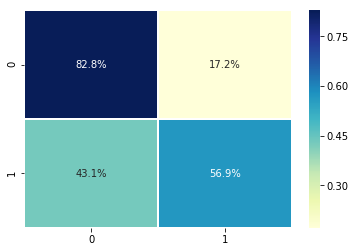

In [20]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=0.3, random_state=42 )

scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

# smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
# sz_train, sy_train = smoter.fit_resample(z_train, y_train)
# gbm = GradientBoostingClassifier()
# gbm.fit(sz_train, sy_train)
# predictions = gbm.predict(z_test)

svmT = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmT.fit(z_train, y_train)

predictions = svmT.predict(z_test)


print('Balanced Accuracy: ', np.around(balanced_accuracy_score(y_test, predictions)*100, 2) )

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

Essa mudança não afetou muito o SVM, mas afetou o GBM. Ver com o Rafael depois o que é melhor, deixar algo que não bata muito com a descrição mas que ajude a predição para algum algoritmo específico, ou deixar o dataset mais coerente com o esperado.

#### Feature MARRIAGE

* **`MARRIAGE:`** status marital (1: casado, 2: solteiro, 3: outros)

**Problemas Encontrados:**

* Valores não documentados para **`MARRIAGE`** (0)

In [21]:
df.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [0]:
df.MARRIAGE[df.MARRIAGE == 0] = 3

Balanced Accuracy:  69.88


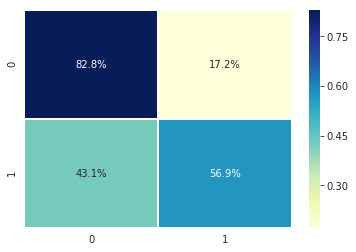

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=0.3, random_state=42 )

scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

# smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
# sz_train, sy_train = smoter.fit_resample(z_train, y_train)
# gbm = GradientBoostingClassifier()
# gbm.fit(sz_train, sy_train)
# predictions = gbm.predict(z_test)

svmT = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
svmT.fit(z_train, y_train)
predictions = svmT.predict(z_test)


print('Balanced Accuracy: ', np.around(balanced_accuracy_score(y_test, predictions)*100, 2) )

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

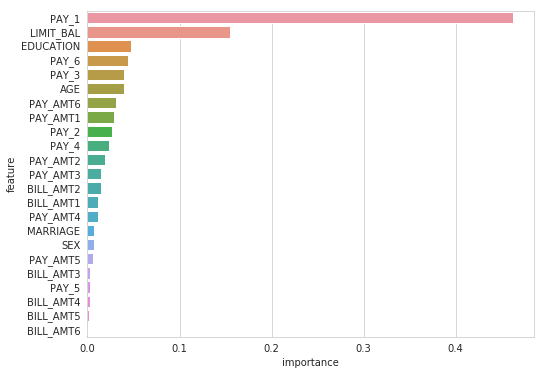

In [29]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbm.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)

Para a feature Marriage, a alteração dos valores não teve muito efeito. Dessa forma, iremos manter a alteração para deixar o Dataset mais próximo dos valores esperados de acordo com a descrição.

### Feature Engineering

Um detalhe que pode ser interessante para ajudar na predição é a porcentagem de quanto foi pago sobre o que era devido. Iremos adicionar essa feature e testar o resultado.


In [64]:
# df.drop('PPAID', axis=1, inplace=True)

# Somando +1 para evitar campos com zero
df.insert(1,'PPAID', ((df[paymentFields].sum(axis=1)+1) / (df[ownedFields].sum(axis=1)+1)) )
df.head(5)


,ID,PPAID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULTED
0,1,0.089552,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,0.292833,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,0.108397,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,0.036263,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,0.540059,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Balanced Accuracy:  68.85


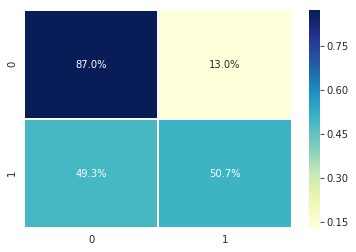

In [67]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=0.3, random_state=42 )

scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoter.fit_resample(z_train, y_train)
gbm = GradientBoostingClassifier()
gbm.fit(sz_train, sy_train)
predictions = gbm.predict(z_test)

# svmT = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
# svmT.fit(z_train, y_train)
# predictions = svmT.predict(z_test)


print('Balanced Accuracy: ', np.around(balanced_accuracy_score(y_test, predictions)*100, 2) )

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

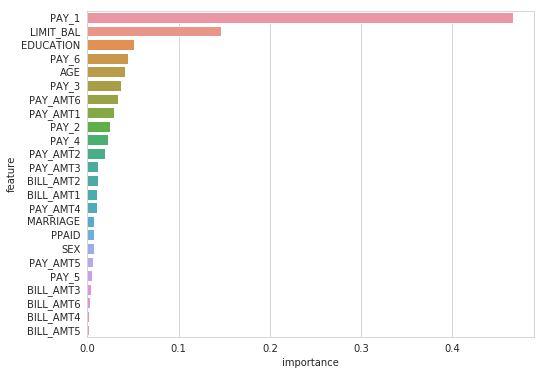

In [68]:
feature_importances = pd.DataFrame({ 'feature': x_train.columns, 'importance': gbm.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)

sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(feature_importances.importance,feature_importances.feature)

In [0]:
df['PPAID'] = df[paymentFields].sum(axis=1) - df[ownedFields].sum(axis=1)

Balanced Accuracy:  68.64


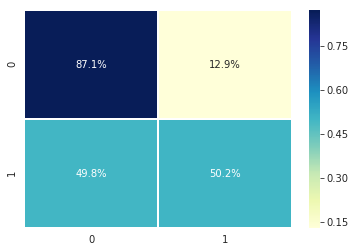

In [70]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:-1],df.iloc[:,-1], test_size=0.3, random_state=42 )

scaler = StandardScaler()
z_train = scaler.fit_transform(x_train)
z_test = scaler.transform(x_test)

smoter = SMOTE(sampling_strategy = 'minority', random_state=777)
sz_train, sy_train = smoter.fit_resample(z_train, y_train)
gbm = GradientBoostingClassifier()
gbm.fit(sz_train, sy_train)
predictions = gbm.predict(z_test)

# svmT = SVC(kernel='rbf', C=1, class_weight='balanced', random_state=999)
# svmT.fit(z_train, y_train)
# predictions = svmT.predict(z_test)


print('Balanced Accuracy: ', np.around(balanced_accuracy_score(y_test, predictions)*100, 2) )

c = confusion_matrix(y_test, predictions)
r = c / c.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
# Matriz de Confusão:
# 	Linhas: Real
# 	Colunas: Predito
sns.heatmap(r, linewidths=.5, cmap='YlGnBu', annot=True, fmt='.1%');

In [71]:
f1_score(y_test, predictions)

0.5107820213042349